In [27]:
import math, csv
import numpy as np
import scipy as sp
import pandas as pd
import pdb

from sklearn.preprocessing import Imputer

%matplotlib inline
import matplotlib.pyplot as plt

In [29]:
tr=pd.read_csv('train.csv')
te=pd.read_csv('test.csv')

target = tr['target']
tr = tr.drop(['ID','target'],axis=1)
IDs = te['ID'].values
te = te.drop(['ID'],axis=1)

# This seems to be a canonical list of data to avoid...
tr = tr.drop(['v8','v23','v25','v31','v36','v37','v46','v51','v53','v54','v63','v73','v75','v79','v81','v82','v89','v92','v95','v105','v107','v108','v109','v110','v116','v117','v118','v119','v123','v124','v128'],axis=1)
te = te.drop(['v8','v23','v25','v31','v36','v37','v46','v51','v53','v54','v63','v73','v75','v79','v81','v82','v89','v92','v95','v105','v107','v108','v109','v110','v116','v117','v118','v119','v123','v124','v128'],axis=1)

tr.head()

,v1,v2,v3,v4,v5,v6,v7,v9,v10,v11,...,v115,v120,v121,v122,v125,v126,v127,v129,v130,v131
0,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,9.999999,0.503281,16.434108,...,2.857144,1.059603,0.803572,8.000000,AU,1.804126,3.113719,0,0.636365,2.857144
1,NaN,NaN,C,NaN,9.191265,NaN,NaN,NaN,1.312910,NaN,...,NaN,NaN,NaN,NaN,AF,NaN,NaN,0,NaN,NaN
2,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,12.666667,0.765864,14.756098,...,12.941177,2.138728,2.238806,9.333333,AE,1.773709,3.922193,2,0.883118,1.176472
3,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,8.965516,6.542669,16.347483,...,10.574713,1.166281,1.956521,7.018256,CJ,1.415230,2.954381,1,1.677108,1.034483
4,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,1.050328,NaN,...,NaN,NaN,NaN,NaN,Z,NaN,NaN,0,NaN,NaN


In [30]:
# Some basic parameters that we'll use a lot
n_tr = tr.shape[0]
n_te = te.shape[0]
n_keys = tr.shape[1]
print n_tr, n_te, n_keys

# Some basic settings that we'll use a lot
predictor_freq_min_ratio = 10
predictor_unique_min_ratio = 20
use_dummies = True
use_random_imputation = False

show_histogram = True

skew_z_thresh = 100.0 # Arbitrary choice, looks legit from histograms

log_trans = True
log_trans_marginals = True
log_trans_shift = 1.0e-6

114321 114393 100


# Data preprocessing
## First we look at distributions (before imputing phase)

Removable predictor? Three training set most common elements:
0    109724
1      2143
2      1198
dtype: int64
['v38']
['v1', 'v6', 'v10', 'v12', 'v13', 'v15', 'v17', 'v18', 'v19', 'v26', 'v32', 'v33', 'v38', 'v39', 'v43', 'v50', 'v55', 'v60', 'v62', 'v72', 'v76', 'v83', 'v84', 'v86', 'v88', 'v90', 'v94', 'v99', 'v102', 'v103', 'v104', 'v120', 'v121', 'v126', 'v129', 'v130', 'v131']


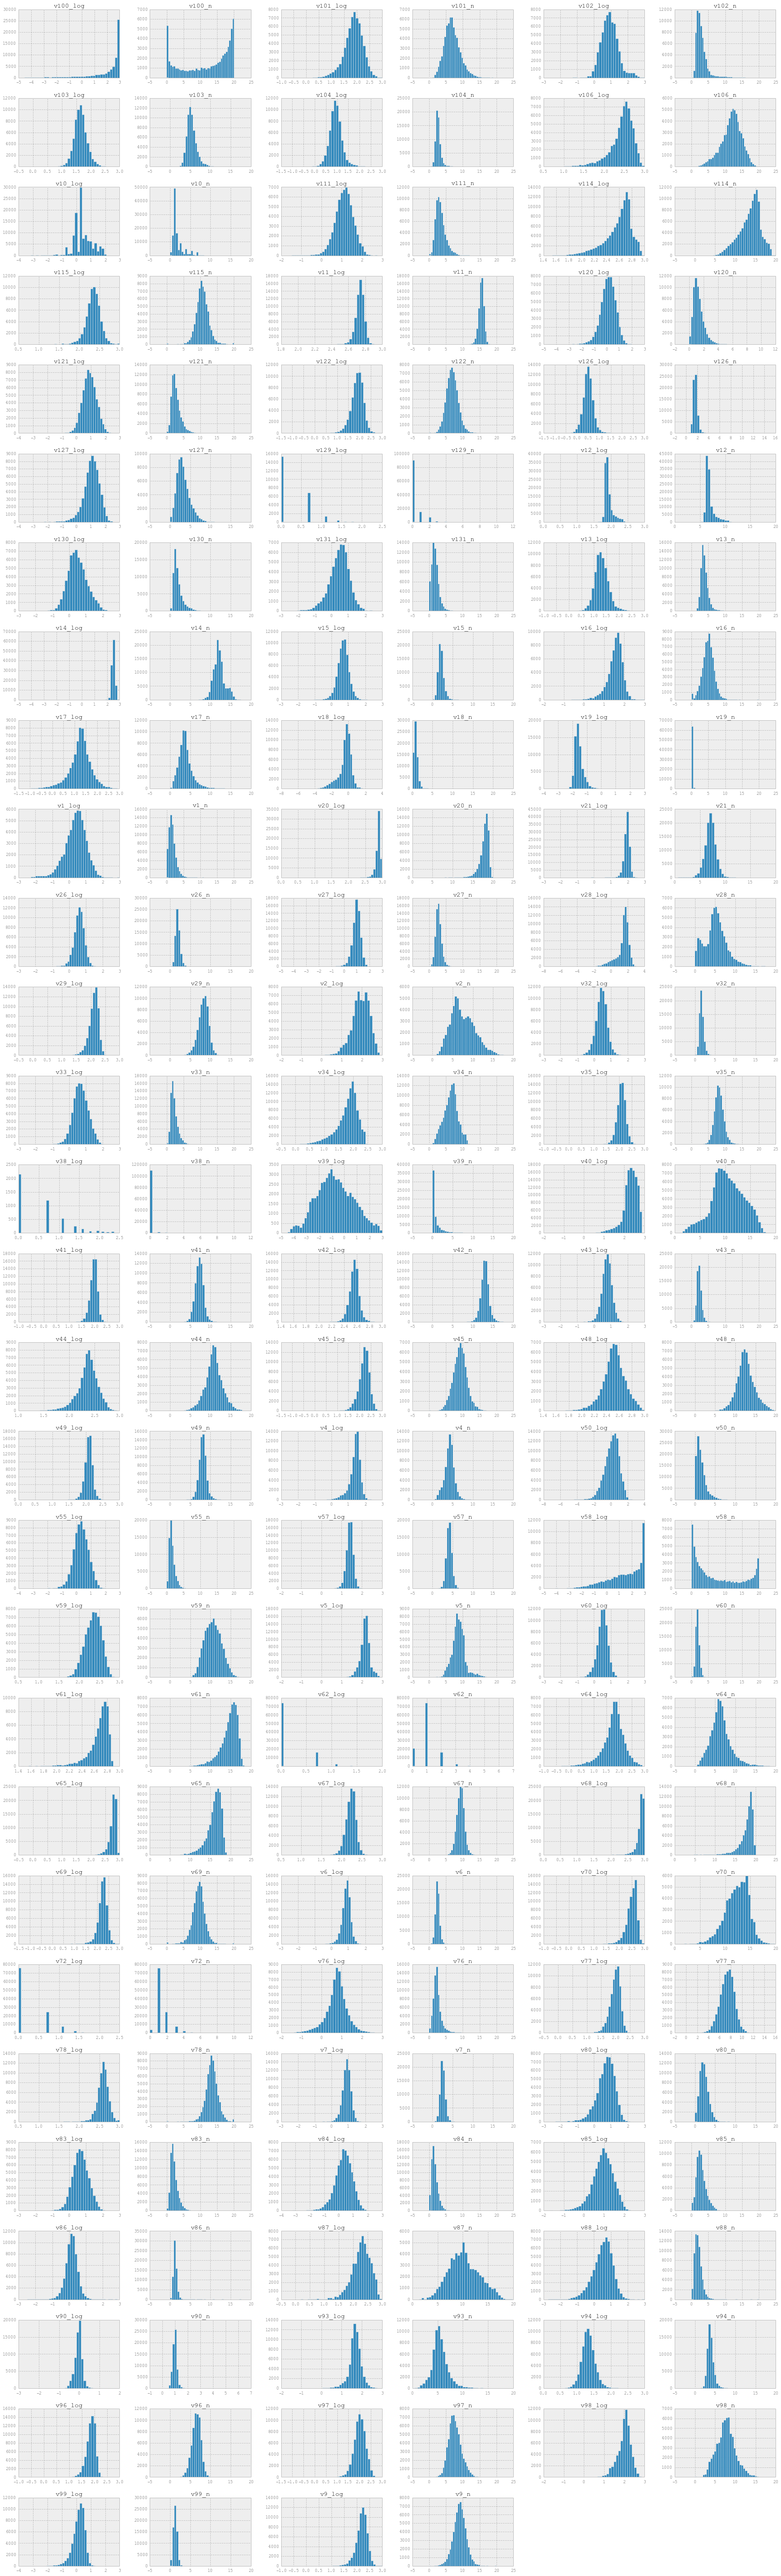

In [31]:
if show_histogram:
    pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
    pd.DataFrame.hist(tr.join(np.log(tr.select_dtypes(exclude=[object])[tr > 1.0e-5]), lsuffix="_n", rsuffix="_log"),
                      figsize=[30,140], layout=[40,6], bins=40)

removable_predictors = []
skewed_predictors = []

for (tr_col_name, tr_col), (te_col_name, te_col) in zip(tr.select_dtypes(exclude=[object]).iteritems(),\
                                                        te.select_dtypes(exclude=[object]).iteritems()):
    if te_col_name != tr_col_name:
        print "Uh oh, mismatched columns", tr_col_name, te_col_name
        
    # We add columns to a list of "removables" if there is too large a ratio between the two most common elements
    tr_val_counts = tr_col.value_counts().ravel()
    te_val_counts = te_col.value_counts().ravel()
    if len(tr_col.unique()) > 2:
        if tr_val_counts[0] / tr_val_counts[1] > predictor_freq_min_ratio and float(n_tr) / float(len(tr_col.unique())) > predictor_unique_min_ratio \
           and te_val_counts[0] / te_val_counts[1] > predictor_freq_min_ratio and float(n_te) / float(len(te_col.unique())) > predictor_unique_min_ratio:
            # The most frequent value is vastly more frequent than the next, in both the training and testing set
            removable_predictors.append(tr_col_name)
            print "Removable predictor? Three training set most common elements:\n", tr_col.value_counts()[tr_col.value_counts().keys()[:3]]

    # We add columns to a list of "skewed" data
    [z,p] = sp.stats.skewtest(tr_col.dropna().ravel())
    if z > skew_z_thresh:
        skewed_predictors.append(tr_col_name)
    
print removable_predictors
print skewed_predictors

# These "log-transformable" predictors are chosen simply from inspecting the histograms below...
log_transform = ['v97', 'v95', 'v94', 'v92', 'v8', 'v88', 'v86', 'v85', 'v84', 'v83', 'v76', 'v73',
                 'v60', 'v55', 'v50', 'v46', 'v39', 'v33', 'v32', 'v25', 'v23', 'v1', 'v19', 'v18', 
                 'v17', 'v15', 'v13', 'v131', 'v130', 'v128', 'v127','v126', 'v124', 'v123', 'v121', 
                 'v120', 'v119', 'v111', 'v109', 'v105', 'v102']
marginal_logs = ['v89', 'v63', 'v54', 'v27', 'v26', 'v118', 'v104']

if log_trans:
    # Then transform all those columns we just listed
    # Note that we could use:
    # from scipy.stats import boxcar
    # BoxCox_Transformed_Data = boxcox(OriginalData)
    # and also see: http://shahramabyari.com/2015/12/21/data-preparation-for-predictive-modeling-resolving-skewness/
    
    for col in log_transform:
        if col in tr.keys():
            tr[col] = np.log(tr[col]+log_trans_shift)
            te[col] = np.log(te[col]+log_trans_shift)
        
    if log_trans_marginals:
        for col in marginal_logs:
            if col in tr.keys():
                tr[col] = np.log(tr[col]+log_trans_shift)
                te[col] = np.log(te[col]+log_trans_shift)

In [32]:
skewed_predictors.sort()
log_transform.sort()

print skewed_predictors
print log_transform

tr.head()

['v1', 'v10', 'v102', 'v103', 'v104', 'v12', 'v120', 'v121', 'v126', 'v129', 'v13', 'v130', 'v131', 'v15', 'v17', 'v18', 'v19', 'v26', 'v32', 'v33', 'v38', 'v39', 'v43', 'v50', 'v55', 'v6', 'v60', 'v62', 'v72', 'v76', 'v83', 'v84', 'v86', 'v88', 'v90', 'v94', 'v99']
['v1', 'v102', 'v105', 'v109', 'v111', 'v119', 'v120', 'v121', 'v123', 'v124', 'v126', 'v127', 'v128', 'v13', 'v130', 'v131', 'v15', 'v17', 'v18', 'v19', 'v23', 'v25', 'v32', 'v33', 'v39', 'v46', 'v50', 'v55', 'v60', 'v73', 'v76', 'v8', 'v83', 'v84', 'v85', 'v86', 'v88', 'v92', 'v94', 'v95', 'v97']


,v1,v2,v3,v4,v5,v6,v7,v9,v10,v11,...,v115,v120,v121,v122,v125,v126,v127,v129,v130,v131
0,0.289486,8.727474,C,3.921026,7.915266,2.599278,3.176895,9.999999,0.503281,16.434108,...,2.857144,0.057895,-0.218687,8.000000,AU,0.590077,1.135818,0,-0.451982,1.049823
1,NaN,NaN,C,NaN,9.191265,NaN,NaN,NaN,1.312910,NaN,...,NaN,NaN,NaN,NaN,AF,NaN,NaN,0,NaN,NaN
2,-0.057758,5.310079,C,4.410969,5.326159,3.979592,3.928571,12.666667,0.765864,14.756098,...,12.941177,0.760212,0.805943,9.333333,AE,0.573073,1.366651,2,-0.124296,0.162521
3,-0.226379,8.304757,C,4.225930,11.627438,2.097700,1.987549,8.965516,6.542669,16.347483,...,10.574713,0.153821,0.671168,7.018256,CJ,0.347293,1.083290,1,0.517071,0.033903
4,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,1.050328,NaN,...,NaN,NaN,NaN,NaN,Z,NaN,NaN,0,NaN,NaN


In [33]:
# Find all the columns with string data
string_cols = []
tr_cat_orig = []
te_cat_orig = []

# First we impute missing values / NaN's
tr_keys_orig = tr.keys()
te_keys_orig = te.keys()
# Now we take care of categorical variables
for (tr_col_name, tr_col), (te_col_name, te_col) in zip(tr.iteritems(),te.iteritems()):

    if tr_col.dtype == 'object':
        
        n_uniques = len(tr_col.unique())
        
        # First we take care of missing values
        tr_tmp_len = len(tr[tr_col.isnull()])
        if tr_tmp_len>0:
            print "Filling for", tmp_len, "NaNs in object data", tr_col_name
            # There's few enough to do a randomised imputation...
            tr.loc[tr_col.isnull(), tr_col_name] = np.random.choice(tr_col.value_counts().keys().ravel(), size=tr_tmp_len,
                             p = tr_col.value_counts(normalize=True).ravel() / tr_col.value_counts(normalize=True).ravel().sum() )
            
        te_tmp_len = len(te[te_col.isnull()])
        if te_tmp_len>0:
            te.loc[te_col.isnull(), te_col_name] = np.random.choice(te_col.value_counts().keys().ravel(), size=te_tmp_len,
                             p = te_col.value_counts(normalize=True).ravel() / te_col.value_counts(normalize=True).ravel().sum() )                                                            
                             #np.float32(te_col.value_counts().ravel()) / te_col.value_counts().ravel().sum() )
            # NB This only replaces NaNs in the ORIGINAL TABLE, tr_col seems to be a COPY OF THE COLUMN

            # Most common imputation
            #tr.loc[tr_col.isnull(), tr_col_name] = tr_col.value_counts().keys()[0]
            # Mean
            #tr.loc[tr_col.isnull(), tr_col_name] = tr_col.mean()
            
        # Now fill with dummies or factorise
        string_cols.append(tr_col_name)
        if n_uniques < 100 and use_dummies:
            print "Adding", n_uniques, "dummies for", tr_col_name
            tr_dum = pd.get_dummies(tr_col, prefix=tr_col_name)
            te_dum = pd.get_dummies(te_col, prefix=te_col_name)

            # There's not *too* many encodings, so we replace the 
             # categorical variables with dummy columns
            tr = tr.drop([tr_col_name], axis=1)
            te = te.drop([te_col_name], axis=1)
            tr = pd.concat([tr, tr_dum], axis=1)
            te = pd.concat([te, te_dum], axis=1)
        else:
            print "Numerising", tr_col_name
            # If there's too many unique values, just make it numerical
            [tr_fac, tr_lab] = pd.factorize(tr[tr_col_name])
            tr[tr_col_name] = tr_fac
            tr_cat_orig.append(tr_lab)
            [te_fac, te_lab] = pd.factorize(te[te_col_name])
            te[te_col_name] = te_fac
            te_cat_orig.append(te_lab)
    else:
        # Numeric type - try an imputation scheme - stolen from HBA        
        # NOTE I'D REALLY LIKE TO HAVE A DISTRIBUTION BASED RANDOMISED
        # ROUTINE - USE KERNEL DENSITY ESTIMATION FROM SCIKIT LEARN...
        tmp_len = len(tr[tr_col.isnull()])
        print "Filling for", tmp_len, "NaNs in data", tr_col_name
        if tmp_len>0:
            tr.loc[tr_col.isnull(), tr_col_name] = tr_col.mean()
        #and Test
        tmp_len = len(te[te_col.isnull()])
        if tmp_len>0:
            te.loc[te_col.isnull(), te_col_name] = te_col.mean()  #TODO
        
#imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
#imp.fit(tr)
#imp.transform(tr)            
            
print string_cols

Filling for 49832 NaNs in data v1
Filling for 49796 NaNs in data v2
Filling for 49839 NaNs in object data v3
Adding 4 dummies for v3
Filling for 49796 NaNs in data v4
Filling for 48624 NaNs in data v5
Filling for 49832 NaNs in data v6
Filling for 49832 NaNs in data v7
Filling for 49851 NaNs in data v9
Filling for 84 NaNs in data v10
Filling for 49836 NaNs in data v11
Filling for 86 NaNs in data v12
Filling for 49832 NaNs in data v13
Filling for 4 NaNs in data v14
Filling for 49836 NaNs in data v15
Filling for 49895 NaNs in data v16
Filling for 49796 NaNs in data v17
Filling for 49832 NaNs in data v18
Filling for 49843 NaNs in data v19
Filling for 49840 NaNs in data v20
Filling for 611 NaNs in data v21
Filling for 573 NaNs in object data v22
Numerising v22
Adding 5 dummies for v24
Filling for 49832 NaNs in data v26
Filling for 49832 NaNs in data v27
Filling for 49832 NaNs in data v28
Filling for 49832 NaNs in data v29
Filling for 49879 NaNs in object data v30
Adding 8 dummies for v30
Fi

In [34]:
import xgboost as xgb
xgtr = xgb.DMatrix(tr.values, target.values)
xgte = xgb.DMatrix(te.values)

params = {'objective': 'binary:logistic', 
          'subsample': 1, 
          'eta': 0.1,                    # eta : step size shrinkage on each boosting step
          #'gamma': 0.0,                 # minimum loss reduction requireed to make a further partition
          #'lambda': 1.0,                # L2 regularization term on weights
          #'alpha': 0.0,                 # L1 regularization term on weights
          'colsample_bytree': 0.9,       # subsample ratio of columns when constructing each tree
          'max_depth': 10,               # maximum depth of a single tree, default = 6
          'min_child_weight' : 5,        # minimum sum of weight needed in a child, default = 1
          'silent': 0 }

boost_round = 1800 
#clf = xgb.cv(params, xgtr, num_boost_round=num_round, metrics={'logloss'}, nfold=5,
#             seed=0, maximize=False)

clf = xgb.train(params, xgtr, num_boost_round=boost_round, verbose_eval=True, maximize=False)

#Make predict
print('Predict...')
test_preds = clf.predict(xgte, ntree_limit=clf.best_iteration)
# Save results
#
predictions_file = open("simple_xgboost_result.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["ID", "PredictedProb"])
open_file_object.writerows(zip(IDs, test_preds))
predictions_file.close()
#
print('Done.')

Predict...
Done.


In [ ]:
print tr.keys()
#print tr_keys_orig

#[tr_fac, tr_lab] = pd.factorize(tr['v22'])
#tr['v22'] = tr_fac
#tr['v56'].unique()

In [ ]:
# Testing out some techniques on dataframes
n = 10
choices = range(n/2)
df = pd.DataFrame({'a': np.random.normal(0,1,n), 'b' : np.random.choice(choices,n)})
print df
print df['b'].unique()
print np.bincount(df['b'])
print np.float32(np.bincount(df['b'])) /len(df['b'])
print np.float32(df['b'].value_counts().ravel()) / len(df['b'])

np.random.choice(df['b'].value_counts().keys().ravel(), size=3,
                             p = np.float32(df['b'].value_counts().ravel()) / df['b'].value_counts().ravel().sum() )

#unique_values = np.sort(tr.ix[:,i].unique())    
#if unique_values.dtype in [np.int64, np.float64]:
#    field_hist, field_bins = np.histogram(tr.ix[:,i], unique_values)